In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import datetime
import ssl
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lenguyen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

nlp = spacy.load("en_core_web_sm")
def cleanData(messages):
    for i in range(0,len(messages)):
        try:
            doc = nlp(messages.iloc[i])
            token_list = [token for token in doc]
            filtered_tokens = [token for token in doc if not token.is_stop]
            lemmas = [token.lemma_ for token in filtered_tokens]
            s = ' '.join(lemmas)
            
            messages.iloc[i] = s
        except:
            messages.iloc[i] = ""
        
        #if is_ascii(messages.iloc[i]) == False:
            # messages.iloc[i] = ""

    return messages

In [4]:
def getSentiment(message):
    return  sia.polarity_scores(message)['compound']

def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

# Single Thread Temporal Analysis

In [23]:
#Load Data
data = pd.read_csv("CleanData/GawaherClean.csv", index_col=0)
threads = data["ThreadID"].unique()
#Load Sentiment analyzer
sia = SentimentIntensityAnalyzer()


In [82]:
#Get thread
num = -4
thread = data[data["ThreadID"]== threads[num]]
thread = thread.reset_index(drop = True)

#get all messages
messages = thread["Message"].copy()
threadName = thread["ThreadName"].iloc[0]

clean = cleanData(messages)


In [83]:

nltkSentiment = []

for i in messages:
    nltkSentiment.append(getSentiment(i))

In [84]:
thread["Sentiment"] = nltkSentiment
print(np.mean(thread["Sentiment"]))

0.029827500000000007


# Order by Datetime 

In [27]:
for i in range(0,len(thread)):
    thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    
thread = thread.sort_values(by = ["P_Date",'﻿MessageID'])

/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_22142/3883651028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])


# Sentiment Time Series

In [28]:
means = []
steps = []
for i in thread["Sentiment"]:
    steps.append(i)
    means.append(np.mean(steps))

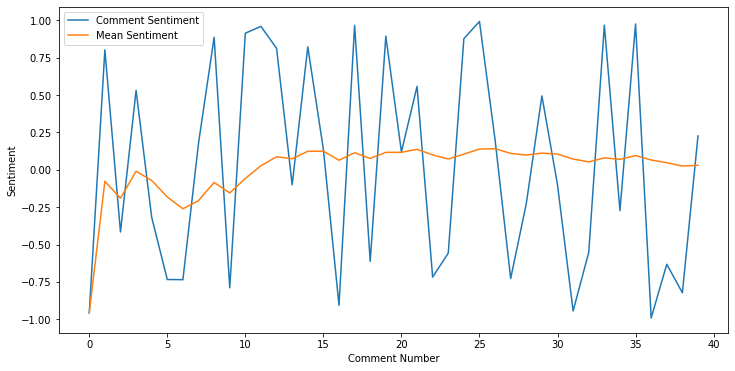

In [29]:
step = np.arange(0,len(thread))
plt.figure(figsize = (12,6))
plt.plot(step, thread["Sentiment"], label = "Comment Sentiment")
plt.plot(step, means, label = "Mean Sentiment")
plt.xlabel("Comment Number")
plt.ylabel("Sentiment")
plt.legend();

# Multi Thread Time Series

In [30]:
def getThread(threadNumber, data):
    threads = data["ThreadID"].unique()
    thread = data[data["ThreadID"]== threads[threadNumber]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    threadName = thread["ThreadName"].iloc[0]
    
    #clean messages
    clean = cleanData(messages)
    
    return clean

def getSentiments(messages):
    nltkSentiment = []
    rollingMean = []
    rollingStd = []

    for i in messages:
        nltkSentiment.append(getSentiment(i))
        rollingMean.append(np.mean(nltkSentiment))
        rollingStd.append(np.std(nltkSentiment))
        
    return nltkSentiment, rollingMean, rollingStd

In [31]:
#Load Data
data = pd.read_csv("CleanData/GawaherClean.csv", index_col=0)
#Load Sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [32]:
plt.figure(figsize = (12,6))
steps = []
sentimentTs = []
sentimentMean = []
sentimentStd = []

for i in range(0,len(data["ThreadID"].unique())):
    thread = getThread(i, data)
    sentiment = getSentiments(thread)
    
    t = np.arange(0,len(sentiment[0]))
    
    steps.append(t)
    sentimentTs.append(sentiment[0])
    sentimentMean.append(sentiment[1])
    sentimentStd.append(sentiment[2])
    

<Figure size 864x432 with 0 Axes>

Do negitavely sentimented threads have higher std?
Get OP mean sentiment, maybe track the sentiment change in individual users

0.867 0.2709717948717949


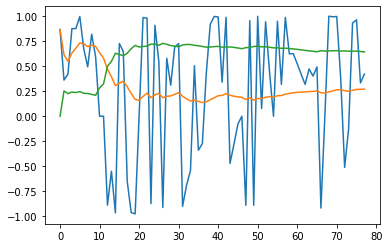

In [79]:
i = 0
plt.plot(steps[i],sentimentTs[i])
plt.plot(steps[i],sentimentMean[i])
plt.plot(steps[i],sentimentStd[i])
print(sentimentTs[i][0], sentimentMean[i][-1])

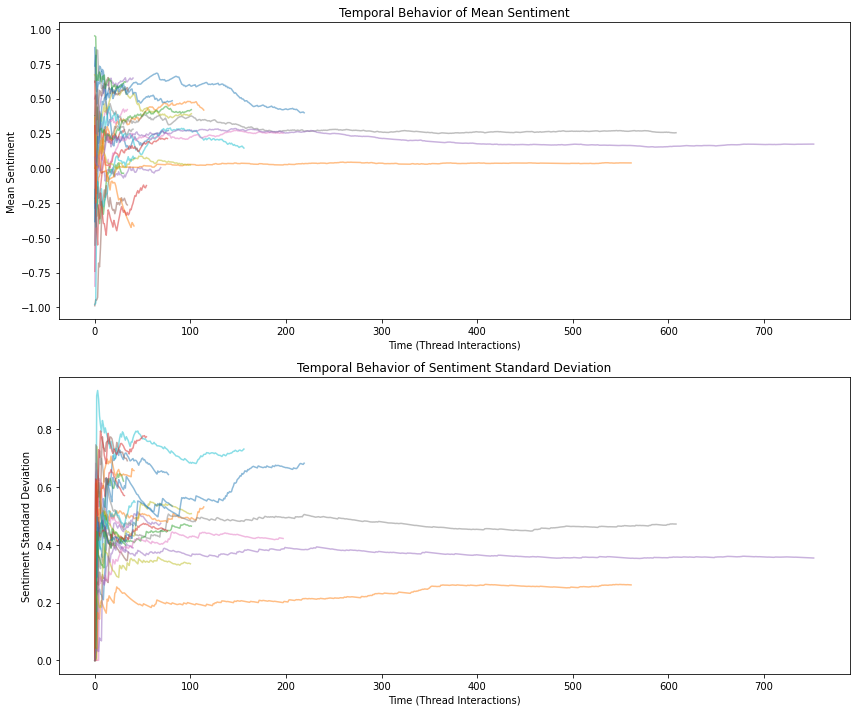

In [77]:
plt.figure(figsize = (12,10))

n = 25#len(steps)

plt.subplot(2,1,1)
for i in range(0,n):
    plt.plot(steps[i],sentimentMean[i], alpha = .5)
plt.xlabel("Time (Thread Interactions)")
plt.ylabel("Mean Sentiment")
plt.title("Temporal Behavior of Mean Sentiment")

plt.subplot(2,1,2)
for i in range(0,n):
    plt.plot(steps[i],sentimentStd[i], alpha = .5)
plt.xlabel("Time (Thread Interactions)")
plt.ylabel("Sentiment Standard Deviation")
plt.title("Temporal Behavior of Sentiment Standard Deviation")

plt.tight_layout()

In [68]:
color = []
stds = []
means = []
count = 0
for i in sentimentMean:
    if i[0] >= 0:
        color.append(0)
    else:
        color.append(1)
    stds.append(sentimentStd[count][-1])
    means.append(i[-1])
    count +=1

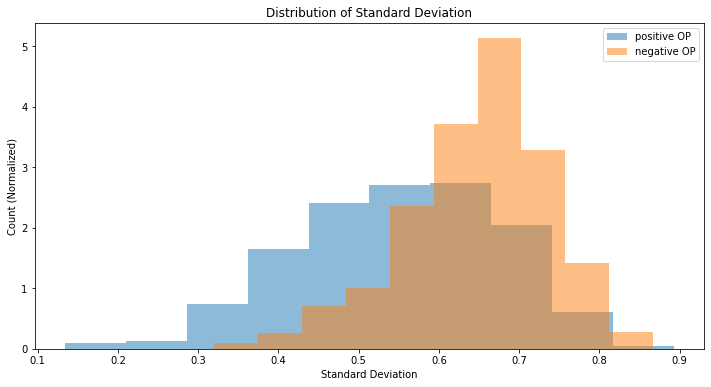

In [71]:
plt.figure(figsize = (12,6))

plt.hist(np.array(stds)[np.array(color) == 0], alpha = .5, label = "positive OP", density = True)
plt.hist(np.array(stds)[np.array(color) == 1], alpha = .5, label = "negative OP", density = True)
plt.title("Distribution of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Count (Normalized)")
plt.legend()

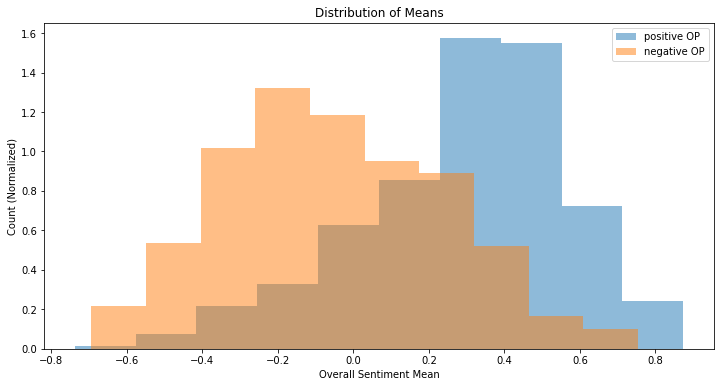

In [74]:
plt.figure(figsize = (12,6))

plt.hist(np.array(means)[np.array(color) == 0], alpha = .5, label = "positive OP", density = True)
plt.hist(np.array(means)[np.array(color) == 1], alpha = .5, label = "negative OP", density = True)
plt.title("Distribution of Means")
plt.xlabel("Overall Sentiment Mean")
plt.ylabel("Count (Normalized)")
plt.legend()

# Temporal Centralitiy Analysis

In [150]:
steps = []
centralityTs = []

#Get thread
for num in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[num]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    threadName = thread["ThreadName"].iloc[0]

    clean = cleanData(messages)

    nltkSentiment = []
    for i in messages:
        nltkSentiment.append(getSentiment(i)) 
    thread["Sentiment"] = nltkSentiment

    encoder = dict(zip(thread["MemberID"].unique(),np.arange(0,len(thread["MemberID"].unique()))))
    thread["MemberID"] = thread["MemberID"].map(encoder)

    edges = []
    poster = []
    for i in range(0,len(thread)-1):
        poster.append(thread["MemberID"].iloc[i])
        edges.append([thread["MemberID"].iloc[i],thread["MemberID"].iloc[i+1]])

    centralMembers = []
    for step in range(1,len(poster)):
        G = nx.Graph()
        thisPoster = poster[:step+1]
        thisEdge = edges[:step]

        G.add_nodes_from(thisPoster)
        G.add_edges_from(thisEdge)
        nodeDict = dict(zip(thisPoster,thread["Sentiment"].iloc[:step+1].to_numpy()))

        infoCentrality = nx.information_centrality(G)
        centralMember = list(infoCentrality.keys())[list(infoCentrality.values()).index(max(infoCentrality.values()))]

        centralMembers.append(centralMember)
        
    centralityTs.append(centralMembers)
    steps.append(np.arange(0,len(centralMembers)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/algorithms/centrality/current_flow_closeness.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  betweenness[v] = 1.0 / (betweenness[v])


Text(0.5, 0, 'Time (Thread Interactions)')

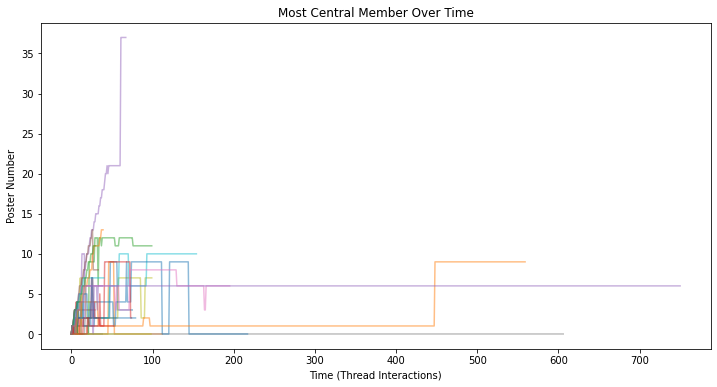

In [167]:
plt.figure(figsize = (12,6))

for i in range(0,25):#len(steps)):
    plt.plot(steps[i],centralityTs[i],alpha = .5)
    
plt.title("Most Central Member Over Time")
plt.ylabel("Poster Number")
plt.xlabel("Time (Thread Interactions)")

Text(0, 0.5, 'Log Count')

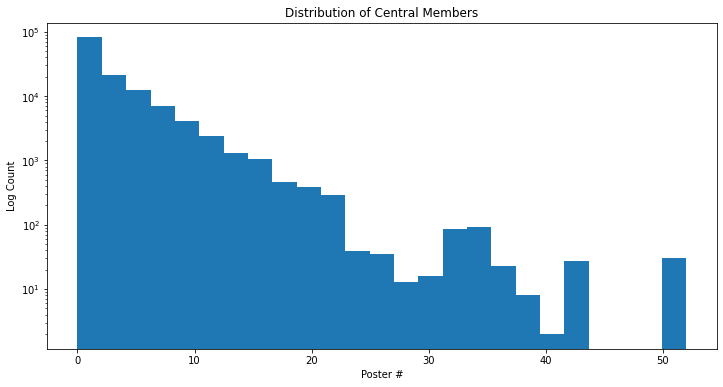

In [166]:
plt.figure(figsize = (12,6))
plt.hist(np.concatenate(centralityTs), bins = 25)
plt.yscale("log")
plt.title("Distribution of Central Members")
plt.xlabel("Poster #")
plt.ylabel("Log Count")


In [184]:
centalityTs = np.array(centralityTs)
sentimentTs = np.array(sentimentTs)
sentimentMean = np.array(sentimentMean)
sentimentStd = np.array(sentimentStd)

/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_22142/933707059.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  centalityTs = np.array(centralityTs)
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_22142/933707059.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentimentTs = np.array(sentimentTs)
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_22142/933707059.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different le

In [186]:
np.savetxt("Centrality.csv", centalityTs, fmt='%s')
np.savetxt("Sentiment.csv", sentimentTs, fmt='%s')
np.savetxt("SentimentMean.csv", sentimentMean, fmt='%s')
np.savetxt("SentimentStd.csv", sentimentStd, fmt='%s')